# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Importing Data

In [9]:
# get all train data
X_butterfly_a = pd.read_csv('../data-4cams/data-butterfly/red_ball_coordinates_128px_2024-03-08_14h11m.csv', decimal='.', delimiter=',')
X_butterfly_b = pd.read_csv('../data-4cams/data-butterfly/red_ball_coordinates_128px_2024-03-08_14h19m.csv', decimal='.', delimiter=',')
X_butterfly_c = pd.read_csv('../data-4cams/data-butterfly/red_ball_coordinates_128px_2024-03-08_14h23m.csv', decimal='.', delimiter=',')
X_spiral_a = pd.read_csv('../data-4cams/data-spiral/red_ball_coordinates_128px_2024-03-08_14h30m.csv', decimal='.', delimiter=',')
X_spiral_b = pd.read_csv('../data-4cams/data-spiral/red_ball_coordinates_128px_2024-03-08_14h34m.csv', decimal='.', delimiter=',')
X_spiro_a = pd.read_csv('../data-4cams/data-spiro/red_ball_coordinates_128px_2024-03-08_14h38m.csv', decimal='.', delimiter=',')
X_spiro_b = pd.read_csv('../data-4cams/data-spiro/red_ball_coordinates_128px_2024-03-08_14h41m.csv', decimal='.', delimiter=',').iloc[:800]

(800, 8)

In [8]:
# get all the position data
y_butterfly_a = pd.read_csv('../data-4cams/data-butterfly/positions_xyz_2024-03-08_14h11m.csv', decimal='.', delimiter=',').iloc[4:]
y_butterfly_b = pd.read_csv('../data-4cams/data-butterfly/positions_xyz_2024-03-08_14h19m.csv', decimal='.', delimiter=',').iloc[4:]
y_butterfly_c = pd.read_csv('../data-4cams/data-butterfly/positions_xyz_2024-03-08_14h23m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_a = pd.read_csv('../data-4cams/data-spiral/positions_xyz_2024-03-08_14h30m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiral_b = pd.read_csv('../data-4cams/data-spiral/positions_xyz_2024-03-08_14h34m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiro_a = pd.read_csv('../data-4cams/data-spiro/positions_xyz_2024-03-08_14h38m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiro_b = pd.read_csv('../data-4cams/data-spiro/positions_xyz_2024-03-08_14h41m.csv', decimal='.', delimiter=',').iloc[4:]
y_spiro_b = y_spiro_b.iloc[:800]

(800, 3)

#### 2.1 Check for Missing Values in spriral_down_b and spiral_down_c

In [10]:
print(f'The amount of NaN in spiral_down_b: {X_butterfly_a.isna().sum().sum()}')
print(f'The amount of NaN in spiral_down_c: {X_butterfly_b.isna().sum().sum()}')
print(f'The amount of NaN in butterfly_a: {X_butterfly_c.isna().sum().sum()}')
print(f'The amount of NaN in spiral_a: {X_spiral_a.isna().sum().sum()}')
print(f'The amount of NaN in spiral_b: {X_spiral_b.isna().sum().sum()}')
print(f'The amount of NaN in spiro_a: {X_spiro_a.isna().sum().sum()}')
print(f'The amount of NaN in spiro_b: {X_spiro_b.isna().sum().sum()}')

The amount of NaN in spiral_down_b: 6
The amount of NaN in spiral_down_c: 2
The amount of NaN in butterfly_a: 6
The amount of NaN in spiral_a: 2168
The amount of NaN in spiral_b: 8
The amount of NaN in spiro_a: 0
The amount of NaN in spiro_b: 4


In [5]:
X_spiral_down_b.shape, y_spiral_down_b.shape, X_spiral_down_c.shape, y_spiral_down_c.shape

((1017, 14), (1017, 3), (999, 14), (999, 3))

In [6]:
X_spiral_down_b.reset_index(drop=True, inplace=True)
y_spiral_down_b.reset_index(drop=True, inplace=True)
X_spiral_down_c.reset_index(drop=True, inplace=True)
y_spiral_down_c.reset_index(drop=True, inplace=True)

In [7]:
combined_b = pd.concat([X_spiral_down_b, y_spiral_down_b], axis=1)
combined_c = pd.concat([X_spiral_down_c, y_spiral_down_c], axis=1)
combined_b.isna().sum().sum(), combined_c.isna().sum().sum()

(3866, 3536)

#### 2.2 Remove Missing Values
Ball is outside of the building in the last 300 frames

In [8]:
combined_b = combined_b[:720]
combined_c = combined_c[:720]
combined_b = combined_b.reset_index(drop=True)
combined_c = combined_c.reset_index(drop=True)
# remaining missing values
combined_b.isna().sum().sum(), combined_c.isna().sum().sum()

(34, 0)

In [9]:
X_spiral_down_b = combined_b.iloc[:, :14]
y_spiral_down_b = combined_b.iloc[:, 14:]
X_spiral_down_c = combined_c.iloc[:, :14]
y_spiral_down_c = combined_c.iloc[:, 14:]
X_spiral_down_b.shape, y_spiral_down_b.shape, X_spiral_down_c.shape, y_spiral_down_c.shape

((720, 14), (720, 3), (720, 14), (720, 3))

In [10]:
X_train = pd.concat([X_circle_a, X_circle_b, X_circle_c, X_lis_curve_a, X_lis_curve_b, X_lis_curve_c, X_spiral_double_a, X_spiral_double_b, X_spiral_down_a, X_spiral_down_b, X_spiral_down_c, X_spirograph_a, X_spirograph_int, X_chaos])
y_train = pd.concat([y_circle_a, y_circle_b, y_circle_c, y_lis_curve_a, y_lis_curve_b, y_lis_curve_c, y_spiral_double_a, y_spiral_double_b, y_spiral_down_a, y_spiral_down_b, y_spiral_down_c, y_spirograph_a, y_spirograph_b, y_chaos])
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,61.0,94.0,43.0,105.0,59.0,87.0,52.5,87.0,36.0,87.5,42.0,80.0,44.5,79.5
1,61.0,94.0,43.0,105.5,59.0,87.0,53.0,87.0,36.0,88.0,42.0,80.0,44.5,79.5
2,61.0,95.0,43.0,105.5,59.0,88.0,52.5,87.5,36.0,88.0,42.0,81.0,44.0,81.0
3,61.0,95.5,43.0,107.0,59.5,88.0,52.5,87.5,36.0,89.0,42.0,81.0,44.5,81.0
4,61.0,96.0,43.0,107.0,60.0,88.5,53.0,89.0,36.0,89.0,42.0,81.0,44.5,81.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13071,76.5,83.0,60.0,93.0,75.0,75.5,68.0,75.0,52.0,75.5,57.0,68.5,60.0,68.0
13072,77.0,83.0,60.0,93.0,75.0,76.0,69.0,76.0,52.0,76.0,57.0,69.0,60.0,69.0
13073,80.5,93.0,64.0,103.0,78.5,85.5,72.0,85.5,56.0,85.5,61.0,78.5,64.0,78.0
13074,81.0,93.0,64.0,103.0,78.5,85.5,72.0,85.5,56.0,85.0,61.0,78.0,63.5,78.0


In [11]:
X_train.shape, y_train.shape

((13076, 14), (13076, 3))

In [12]:
combined = pd.concat([X_train, y_train], axis=1)

## 3. Data Preprocessing

In [13]:
# check for missing values
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
print(f'The data has missing values: {combined.isnull().sum().sum()}')

The data has missing values: 80
The data has missing values: 0


In [14]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]

In [15]:
# scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter Tuning

In [16]:
# create a pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(random_state=42))
])

In [17]:
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=3, random_state=42)

random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
49 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
49 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('mlp',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50, 50,
                                                                     50),
                                                                    (50, 100,
                                                                     50),
                                                                    (100,)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=3)

In [18]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_}')

Best parameters: {'mlp__solver': 'sgd', 'mlp__max_iter': 10000, 'mlp__learning_rate_init': 0.1, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (50, 100, 50), 'mlp__early_stopping': True, 'mlp__alpha': 0.001, 'mlp__activation': 'relu'}
Best score: 0.8739659797912133


In [19]:
model = random_search.best_estimator_

## 5. Training the Model

In [20]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(alpha=0.001, early_stopping=True,
                              hidden_layer_sizes=(50, 100, 50),
                              learning_rate='adaptive', learning_rate_init=0.1,
                              max_iter=10000, random_state=42, solver='sgd'))])

## 6. Make Predictions On Test Data

In [21]:
import pandas as pd

In [22]:
# get all test data
X_test_8 = pd.read_csv('../data/data-8/red_ball_coordinates_128px_2024-03-07_15h33m.csv', decimal='.', delimiter=',')
X_test_8

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,81.0,94.0,64.5,104.5,79.0,87.0,72.0,87.0,56.0,86.5,61.0,80.0,64.5,79.5
1,80.5,95.5,63.0,106.0,78.0,88.0,72.0,88.0,55.0,88.0,60.5,81.0,63.0,81.0
2,78.5,97.5,62.0,108.0,77.0,90.0,70.5,90.0,54.0,90.0,59.5,82.0,62.0,82.0
3,78.5,99.0,61.0,110.0,76.5,91.5,70.0,91.5,53.0,91.5,59.0,84.0,61.0,84.0
4,77.5,100.5,60.0,111.5,75.5,92.5,68.5,93.0,52.5,93.0,58.0,85.5,60.5,85.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,72.0,80.0,55.5,90.0,71.0,74.0,64.0,73.0,47.0,73.0,53.0,66.0,56.0,66.0
509,73.0,81.0,56.0,90.0,71.5,73.5,65.0,73.0,48.0,74.0,54.0,67.0,56.0,66.0
510,73.5,81.0,56.5,91.0,72.0,74.0,65.0,74.0,48.0,74.0,54.0,67.0,57.0,67.0
511,75.0,83.0,57.5,93.5,73.0,76.0,67.0,76.0,50.0,75.5,56.0,69.0,58.0,69.0


In [23]:
# get all the position data
y_test_8 = pd.read_csv('../data/data-8/positions_xyz_2024-03-07_15h33m.csv', decimal='.', delimiter=',').iloc[4:]
y_test_8

,x,y,z
4,7.273234,5.135877,21.81421
5,7.405877,5.397035,21.90800
6,7.537339,5.648837,22.00096
7,7.667035,5.886813,22.09267
8,7.794389,6.106740,22.18272
...,...,...,...
512,8.308872,2.973061,22.54652
513,8.198165,3.074144,22.46824
514,8.082750,3.207114,22.38663
515,7.963154,3.369595,22.30206


In [24]:
X_test_rand = pd.read_csv('../data/data-random/red_ball_coordinates_128px_2024-03-07_21h46m.csv', decimal='.', delimiter=',')
y_test_rand = pd.read_csv('../data/data-random/positions_xyz_2024-03-07_21h46m.csv', decimal='.', delimiter=',').iloc[4:]
X_test_rand.shape, y_test_rand.shape

((1005, 14), (1005, 3))

In [25]:
X_test_butterfly = pd.read_csv('../data/data-butterfly/red_ball_coordinates_128px_2024-03-07_22h30m.csv', decimal='.', delimiter=',')
y_test_butterfly = pd.read_csv('../data/data-butterfly/positions_xyz_2024-03-07_22h30m.csv', decimal='.', delimiter=',').iloc[4:]

In [26]:
print(f'The amount of NaN values in butterfly: {X_test_butterfly.isna().sum().sum()}')
combo_butterfly = pd.concat([X_test_butterfly, y_test_butterfly], axis=1)
combo_butterfly = combo_butterfly.dropna()
X_test_butterfly = combo_butterfly.iloc[:, :14]
y_test_butterfly = combo_butterfly.iloc[:, 14:]
print(f'The amount of NaN values after removing: {X_test_butterfly.isna().sum().sum()}')

The amount of NaN values in butterfly: 2
The amount of NaN values after removing: 0


In [27]:
X_test_butterfly_a = pd.read_csv('../data/data-butterfly/red_ball_coordinates_128px_2024-03-07_22h35m.csv', decimal='.', delimiter=',')
y_test_butterfly_a = pd.read_csv('../data/data-butterfly/positions_xyz_2024-03-07_22h35m.csv', decimal='.', delimiter=',').iloc[4:]
X_test_butterfly_a.isna().sum().sum(), y_test_butterfly_a.isna().sum().sum()
# X_test_butterfly_a has 112 NaN values, so I interpolated it in TrajectoryPredictionInterpolation.ipynb

(122, 0)

In [28]:
X_test_butterfly_a = pd.read_csv('../data/data-butterfly/red_ball_coordinates_128px_2024-03-07_22h35m_interpolated.csv', decimal='.', delimiter=',')

In [29]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test):
    y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :14]
    y_val = combined_test.iloc[:, 14:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [30]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

Mean Squared Error on Test Data Set: 0.24102268661378765
Mean Absolute Error on Test Data Set: 0.40475983692315093
R2 Score on Test Data set: 0.8262186187296229


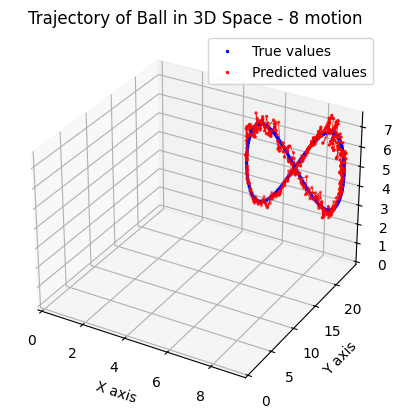

In [31]:
X_test_scaled_8, y_test_8 = prepare_and_scale_test_data(X_test_8, y_test_8, scaler_x)
y_test_pred_8, mse_8, mae_8, r2_8 = predict_evaluate_plot(X_test_scaled_8, y_test_8, model, scaler_y, 'Trajectory of Ball in 3D Space - 8 motion')

Mean Squared Error on Test Data Set: 0.2612823601578545
Mean Absolute Error on Test Data Set: 0.3772354050903082
R2 Score on Test Data set: 0.7190777210336217


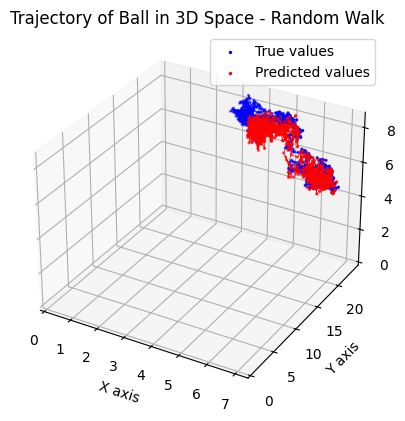

In [32]:
X_test_scaled_rand, y_test_rand = prepare_and_scale_test_data(X_test_rand, y_test_rand, scaler_x)
y_test_pred_rand, mse_rand, mae_rand, r2_rand = predict_evaluate_plot(X_test_scaled_rand, y_test_rand, model, scaler_y, 'Trajectory of Ball in 3D Space - Random Walk')

Mean Squared Error on Test Data Set: 0.159314904562303
Mean Absolute Error on Test Data Set: 0.2873045769407349
R2 Score on Test Data set: 0.8736060476304836


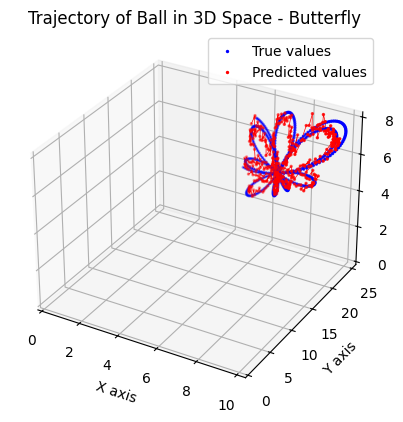

In [33]:
X_test_butterfly_scaled, y_test_butterfly = prepare_and_scale_test_data(X_test_butterfly, y_test_butterfly, scaler_x)
y_test_pred_butterfly, mse_butterfly, mae_butterfly, r2_butterfly = predict_evaluate_plot(X_test_butterfly_scaled, y_test_butterfly, model, scaler_y, 'Trajectory of Ball in 3D Space - Butterfly')

Mean Squared Error on Test Data Set: 0.38369220463394504
Mean Absolute Error on Test Data Set: 0.4127723391797577
R2 Score on Test Data set: 0.8884773301366987


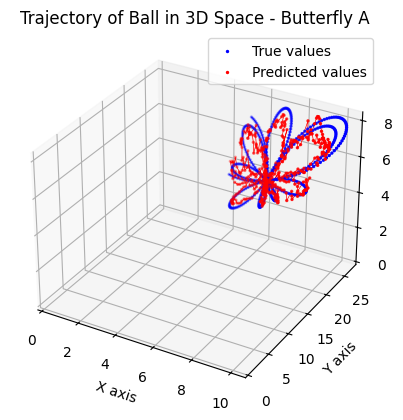

In [34]:
X_test_butterfly_a_scaled, y_test_butterfly_a = prepare_and_scale_test_data(X_test_butterfly_a, y_test_butterfly_a, scaler_x)
y_test_pred_butterfly_a, mse_butterfly_a, mae_butterfly_a, r2_butterfly_a = predict_evaluate_plot(X_test_butterfly_a_scaled, y_test_butterfly_a, model, scaler_y, 'Trajectory of Ball in 3D Space - Butterfly A')